In [1]:
%load_ext autoreload
%autoreload 2

from operaDB import OperaDB
from omronEyeLib import OmronEye
from imageLib import OperaImage
from sensorLib import *
import math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

#Connection to opera DB
opera = OperaDB('opera_conn.xml', 'lifelog-shimizu')
#cur.execute("select version()")
#print(cur.fetchall())

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


connect to opera server


In [2]:
#Get time from video
#desire_date = '2018-07-27'
#desire_date = '2018-08-22'
#desire_date = '2018-09-19'
desire_date = '2018-09-26'

#opera.get_TripListFromTime('2018-09-19', '00:00:00.0000', '23:59:59')
tripLists = opera.get_TripListFromTime(desire_date)
print(tripLists)

                                     id     start_time   length  \
0  6ddb9062-c12c-11e8-ad67-06dc25b93fb2  1537925720190     9973   
1  8b8e87ea-c12c-11e8-ad67-06dc25b93fb2  1537925770180     4822   
2  d70251de-c12c-11e8-ad67-06dc25b93fb2  1537925896758    35510   
3  0c661892-c12d-11e8-ad67-06dc25b93fb2  1537925986346  1588560   
4  de9157c8-c132-11e8-ad7b-06dc25b93fb2  1537928486195    29276   
5  340d32ee-c133-11e8-ad7c-06dc25b93fb2  1537928629543   514081   

                                user_id  
0  687b7332-3c82-11e8-91ea-06dc25b93fb2  
1  687b7332-3c82-11e8-91ea-06dc25b93fb2  
2  687b7332-3c82-11e8-91ea-06dc25b93fb2  
3  687b7332-3c82-11e8-91ea-06dc25b93fb2  
4  687b7332-3c82-11e8-91ea-06dc25b93fb2  
5  687b7332-3c82-11e8-91ea-06dc25b93fb2  


In [3]:
#OBD data
obd = OBD( opera )
column_names, df_obd = obd.get_DataFrameFromTrip( tripLists, 3, -20 )

['id', 'time', 'vehicle_speed', 'relative_accelerator_pedal_position', 'user_id']


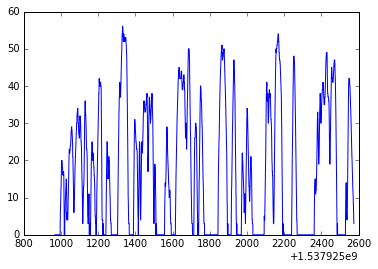

In [4]:
import matplotlib.pyplot as plt
print(column_names)
plt.plot(df_obd['time']/1000,df_obd['vehicle_speed'])
plt.show()

In [4]:
#Sensor data
sensor = Sensors( opera )
sensor.get_ListSensorType()

sensor name : sensor type
BMP280 temperature : 65536
BMI160 accelerometer : 1
BMM150 magnetometer : 2
Orientation : 3
BMI160 gyroscope : 4
TMD27723 Light Sensor : 5
BMP280 pressure : 6
Gravity : 9
Linear Acceleration : 10
Rotation Vector : 11
BMM150 magnetometer (uncalibrated) : 14
Game Rotation Vector : 15
BMI160 gyroscope (uncalibrated) : 16
Geomagnetic Rotation Vector : 20
BMI160 accelerometer (uncalibrated) : 35
You need more information, Please see below
https://developer.android.com/reference/android/hardware/Sensor


In [20]:
column_names, df_sensor = sensor.get_DataFrameFromTripWithSensorType( 1, tripLists, 3, -20 )
print(df_sensor)

                                        id           time sensor_type  \
0     0087f686-c12d-11e8-ad67-06dc25b93fb2  1537925966353           1   
1     00a58a86-c12d-11e8-ad67-06dc25b93fb2  1537925966553           1   
2     00c82f3d-c12d-11e8-ad67-06dc25b93fb2  1537925966772           1   
3     00e3abec-c12d-11e8-ad67-06dc25b93fb2  1537925966989           1   
4     01028208-c12d-11e8-ad67-06dc25b93fb2  1537925967189           1   
5     011fee9b-c12d-11e8-ad67-06dc25b93fb2  1537925967390           1   
6     013e7a4c-c12d-11e8-ad67-06dc25b93fb2  1537925967590           1   
7     015e3595-c12d-11e8-ad67-06dc25b93fb2  1537925967807           1   
8     017e6306-c12d-11e8-ad67-06dc25b93fb2  1537925968008           1   
9     019d97b6-c12d-11e8-ad67-06dc25b93fb2  1537925968209           1   
10    01dbd5bb-c12d-11e8-ad67-06dc25b93fb2  1537925968427           1   
11    01f93ba2-c12d-11e8-ad67-06dc25b93fb2  1537925968653           1   
12    02174f15-c12d-11e8-ad67-06dc25b93fb2  1537925

['id', 'time', 'sensor_type', 'sensor_name', 'accuracy', 'sensor_values', 'model', 'timestamp', 'user_id']


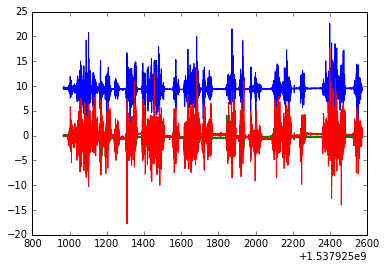

In [21]:
print(column_names)

num, vals = sensor.get_values( df_sensor['sensor_values'] )

import matplotlib.pyplot as plt
plt.plot(df_sensor['time']/1000, vals)
plt.show()

In [25]:
import numpy as np
import pandas as pd
import urllib.request
import folium
from IPython.display import display
from scipy import signal, interpolate

sTimeStamp = df_sensor['time'][0]
eTimeStamp = df_sensor['time'][len(df_sensor['time'])-1]

gps = GPS( opera )
column_names, df_gps = gps.get_DataFrameFromTime( sTimeStamp, eTimeStamp )

ay = np.array([])
for v in vals:
    ay = np.append(ay, v[1])

#interpolate linear
f_sensor = interpolate.interp1d(np.array(df_sensor['time'],dtype=np.float),ay)
sensor_interpolate = f_sensor(np.array(df_gps['time'],dtype=np.float))

loc = [df_gps['latitude'][0], df_gps['longitude'][0]]
map_obj =folium.Map(location=loc, zoom_start=14)
for i in range(len(df_gps['latitude'])):
    if( sensor_interpolate[i] > 0 ):
        folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=sensor_interpolate[i],popup='',color='red', fill_color='#3186cc').add_to(map_obj)
    else:
        folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=sensor_interpolate[i],popup='',color='blue', fill_color='#3186cc').add_to(map_obj)

display(map_obj)

In [26]:
import numpy as np
import pandas as pd
import urllib.request
import folium
from IPython.display import display
from scipy import signal, interpolate

sTimeStamp = df_sensor['time'][0]
eTimeStamp = df_sensor['time'][len(df_sensor['time'])-1]

gps = GPS( opera )
column_names, df_gps = gps.get_DataFrameFromTime( sTimeStamp, eTimeStamp )

ay = np.array([])
for v in vals:
    ay = np.append(ay, v[2])

#interpolate linear
f_sensor = interpolate.interp1d(np.array(df_sensor['time'],dtype=np.float),ay)
sensor_interpolate = f_sensor(np.array(df_gps['time'],dtype=np.float))

loc = [df_gps['latitude'][0], df_gps['longitude'][0]]
map_obj =folium.Map(location=loc, zoom_start=14)
for i in range(len(df_gps['latitude'])):
    if( sensor_interpolate[i] > 0 ):
        folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=sensor_interpolate[i],popup='',color='red', fill_color='#3186cc').add_to(map_obj)
    else:
        folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=sensor_interpolate[i],popup='',color='blue', fill_color='#3186cc').add_to(map_obj)

display(map_obj)